<a href="https://colab.research.google.com/github/kojiyam/machine-learning/blob/main/denso7_regression1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><strong>ニューラルネットワークによる機械学習をあえて用いた線形回帰</strong></h1>

ニューラルネットワークを用いた教師あり学習・回帰問題について，機械学習フレームワーク<strong>PyTorch</strong>を用いた，極端に簡単な例を示す．

文章も含め，以下のページに記載のプログラムを流用させて頂いた上で，さらに簡単にしたものである．

<a href="https://axa.biopapyrus.jp/deep-learning/pytorch/regression.html">PyTroch で実装したニューラルネットワークで簡単な回帰問題を解く --- 回帰（1 特徴量）</a>

In [ ]:
#@title 一般的ライブラリ
import numpy as np
np.random.seed(1)
import matplotlib.pyplot as plt
plt.style.use('dark_background') # Dark-mode
from tqdm import tqdm # Progress bar

In [ ]:
#@title 機械学習フレームワーク PiTorch
import torch
import torch.nn.functional
import torch.utils.data
torch.manual_seed(1)

## <strong>1. 教師データ生成</strong>

$x$ は $(0,10)$の間の一様分布

$ y = 2x + 3 + \epsilon ,\ \epsilon \sim \mathcal{N}(0,1)$

$ y= 2x+3$に標準正規分布に従う雑音項を加えた
$ (x_i,y_i) $ を生成

In [ ]:
#@title 教師データ生成
x = np.random.uniform(low=0, high=10, size=100)
y = 2 * x + 3 + np.random.randn(100)

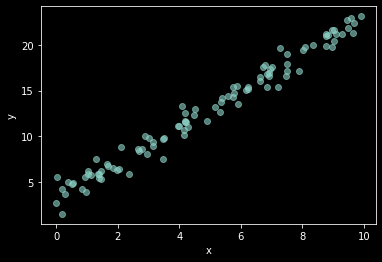

In [ ]:
#@title 図描画
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.scatter(x, y, alpha=0.6)
fig.show()

機械学習では以下のように呼ぶ <br>
$(x_i)$: Inputs <br>
$(y_i)$: Labels, outputs <br>
$f : x \mapsto y $: Model <br>
$(x_i, y_i)$: Labeled data，教師データ

## <strong>2. 回帰問題</strong>

教師データ $(x_i, y_i)$ による，モデル $f$ の訓練を行う．

ニューラルネットワークによる回帰とは，モデル $f$ としてニューラルネットワークで表される関数を用い，ニューラルネットワークのパラメータを調整するということである．

### 2.1 PyTorchによるニューラルネットワークの定義

In [ ]:
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = torch.nn.Linear(1, 1)
  def forward(self, x):
    x = self.fc1(x)    
    return x

ｆ = Net()

`torch.nn.Linear(1, 1)` は， 入力と出力の次元が両方 1 のニューラルネットワークのレイヤを表す．<br>
このレイヤは，後述の活性化関数を $\phi$ として次式を表す．<br>
$y=\phi(wx+b)$

`x = self.fc1(x)` は活性化関数が $\phi(z)=z$ であることを表す． したがってこのレイヤは次式を表す．<br>
$y=wx+b$

このモデル $f$，すなわちニューラルネットワークを訓練することは， $w$ と $b$ の推定値を定めることに他ならない

なお，このニューラルネットワークは，入力層，出力層に加えて，1層の隠れ層を持つ，単純パーセプトロンと呼ばれるものである．

隠れ層の数や，隠れ層のニューロンの数を増やせば（ディープニューラルネットワーク），モデル，すなわち関数 $f$ の表現力が高まる．
これを使うのが<strong>深層学習</strong>である．


## <strong>3. 教師データによる，ニューラルネットワークの訓練</strong>

OptimizerはStochastic gradient descent，損失関数を MSE とする

In [ ]:
#@title PiTorchを使うための準備
x_tensor = torch.from_numpy(x.reshape(-1, 1)).float()
y_tensor = torch.from_numpy(y.reshape(-1, 1)).float()
epoch_loss = []

OptimizerはStochastic gradient descent，損失関数を MSE とする

In [ ]:
#@title Optimizer, 損失関数の設定
optimizer = torch.optim.SGD(ｆ.parameters(), lr=0.01) 
criterion = torch.nn.MSELoss()

In [ ]:
#@title 訓練
ｆ.train()
num_epochs = 1000
for epoch in tqdm(range(num_epochs)):
  loss = criterion(ｆ(x_tensor), y_tensor)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  epoch_loss.append(loss.data.numpy().tolist())

100%|██████████| 1000/1000 [00:00<00:00, 2778.14it/s]


訓練時における損失 `epoch_loss` は、学習の収束状況を表す．

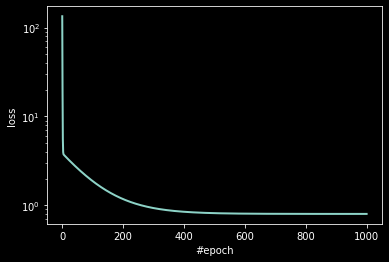

In [ ]:
#@title 図描画
fig = plt.figure()
ax = fig.add_subplot()
ax.set_yscale('log')
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
ax.plot(list(range(len(epoch_loss))), epoch_loss, 
        linewidth=2)
fig.show()

## <strong>4. ニューラルネットワークによる推定</strong>
ニューラルネットワークで予測した回帰曲線の図示を描き込む。このために、0 から 10 までの範囲内で細かい間隔で等差数列を生成して `x` とし、これを上で学習したネットワークに代入して回帰曲線（回帰折れ線）を得る。そして、訓練データと回帰曲線を可視化する。

なお、ネットワークを検証・テストモードで使用するためには、ネットワークに対して `eval()` メソッドを実行する。今回の回帰の例は `train()` と `eval()` を使い分けなくてもよいが、ネットワーク中にバッチ正規化やドロップアウトなどを定義している場合に、切り替えが必要である。また、検証時に微分値でパラメーターの更新を行わないので、無駄な計算を行わないように `torch.no_grad()` の状態で検証する。

In [ ]:
#@title 推定
f.eval()

# テスト入力
# [0,10]の中の等間隔な100点
x_new = np.linspace(0, 10, 100)
x_new_tensor = torch.from_numpy(x_new.reshape(-1, 1)).float()

# テスト入力に対する推定値
with torch.no_grad():
    y_pred_tensor = f(x_new_tensor)
y_pred = y_pred_tensor.data.numpy()


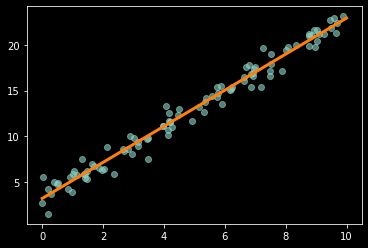

In [ ]:
#@title 図描画
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x, y, alpha=0.6)
ax.plot(x_new, y_pred, c='tab:orange', linewidth=3)
fig.show()

パラメータを表示

$ y = w x + b $ の $w$．2が正解

In [ ]:
print(f.ｆｃ1.weight)

Parameter containing:
tensor([[1.9711]], requires_grad=True)


$ y = w x + b $ の $b$．3が正解

In [ ]:
print(f.ｆｃ1.bias)

Parameter containing:
tensor([3.2195], requires_grad=True)


In [ ]:
# パラメータ閲覧
# https://qiita.com/mathlive/items/d9f31f8538e20a102e14
# print(net)
# for param in net.parameters():
#     print(param)